# HOW TO RUN THIS FILE
1. edit the ROOT_PATH variable to match the path from your google drive to the eva shared folder
2. make sure that the runtime type is set to GPU. the code requires CUDA to work. (you can set it to CPU only mode, but it's about 10x slower)

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
# EDIT THIS VARIABLE:
ROOT_PATH = "/content/drive/MyDrive/CS245 Project Shared/eva"
SRC_PATH = os.path.join(ROOT_PATH, "src")
sys.path.append(SRC_PATH)
from run_dbp15k import *

In [ ]:
def run_eva(emb_sizes=(100,100,200), gcn_emb_size=200, verbose=True, save_emb=False):
    parser = argparse.ArgumentParser()
    parser.add_argument("--file_dir", type=str, default="data/DBP15K/zh_en", required=False, help="input dataset file directory, ('data/DBP15K/zh_en', 'data/DWY100K/dbp_wd')")
    parser.add_argument("--rate", type=float, default=0.3, help="training set rate")
    
    parser.add_argument("--cuda", action="store_true", default=True, help="whether to use cuda or not")
    parser.add_argument("--seed", type=int, default=2021, help="random seed")
    parser.add_argument("--epochs", type=int, default=1000, help="number of epochs to train")
    parser.add_argument("--check_point", type=int, default=100, help="check point")
    parser.add_argument("--hidden_units", type=str, default="128,128,128", help="hidden units in each hidden layer(including in_dim and out_dim), splitted with comma")
    parser.add_argument("--heads", type=str, default="2,2", help="heads in each gat layer, splitted with comma")
    parser.add_argument("--instance_normalization", action="store_true", default=False, help="enable instance normalization")
    parser.add_argument("--lr", type=float, default=0.005, help="initial learning rate")
    parser.add_argument("--weight_decay", type=float, default=0, help="weight decay (L2 loss on parameters)")
    parser.add_argument("--dropout", type=float, default=0.0, help="dropout rate for layers")
    parser.add_argument("--attn_dropout", type=float, default=0.0, help="dropout rate for gat layers")
    parser.add_argument("--dist", type=int, default=2, help="L1 distance or L2 distance. ('1', '2')")
    parser.add_argument("--csls", action="store_true", default=False, help="use CSLS for inference")
    parser.add_argument("--csls_k", type=int, default=10, help="top k for csls")
    parser.add_argument("--il", action="store_true", default=False, help="Iterative learning?")
    parser.add_argument("--semi_learn_step", type=int, default=10, help="If IL, what's the update step?")
    parser.add_argument("--il_start", type=int, default=500, help="If Il, when to start?")
    parser.add_argument("--bsize", type=int, default=7500, help="batch size")
    parser.add_argument("--unsup", action="store_true", default=False)
    parser.add_argument("--unsup_k", type=int, default=1000, help="|visual seed|")
    #parser.add_argument("--long_tail_analysis", action="store_true", default=False)
    parser.add_argument("--lta_split", type=int, default=0, help="split in {0,1,2,3,|splits|-1}")
    args = argparse.Namespace( 
        file_dir=os.path.join(ROOT_PATH, "data/DBP15K/fr_en"), 
        rate=0.3, 
        lr=0.0005, 
        epochs=50, #1000 originally
        hidden_units=f"400,400,{gcn_emb_size}", 
        check_point=50, 
        bsize=7500, 
        il=False, # True originally 
        il_start=500, 
        semi_learn_step=5, 
        csls=True, 
        csls_k=3, 
        seed=0,
    )
    args = parser.parse_args(args=[], namespace=args)
    results = main(
        args, 
        emb_sizes=emb_sizes, 
        save_emb=save_emb, 
        root_path=ROOT_PATH,
        verbose=verbose
    )
    return results

In [ ]:
# default run:
results = run_eva()

loading raw data...
70.69% entities have images
image feature shape: torch.Size([39654, 2048])
#left entity : 19661, #right entity: 19993
#left entity not in train set: 15161, #right entity not in train set: 15493
relation feature shape: torch.Size([39654, 1000])
attribute feature shape: torch.Size([39654, 1000])
-----dataset summary-----
dataset:	 /content/drive/MyDrive/CS245 Project Shared/eva/data/DBP15K/fr_en
triple num:	 221720
entity num:	 39654
relation num:	 2111
train ill num:	 4500 	test ill num:	 10500
-------------------------
getting a sparse tensor r_adj...
GCN model details:
GCN(
  (gc1): GraphConvolution (400 -> 400)
  (gc2): GraphConvolution (400 -> 200)
)
optimiser details:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.01
)
[start training...] 
[epoch 0] loss_all: -6.590823, time: 0.3693 s
[epoch 1] loss_all: -8.103364, time: 0.2652 s
[epoch 2] loss_all: -9.321037, time: 0.2590 s
[epoch 3] loss_a

In [ ]:
acc_l2r, acc_r2l, mean_l2r, mean_r2l, mrr_l2r, mrr_r2l = results
print(acc_l2r)
print(acc_r2l)
print(mean_l2r)
print(mean_r2l)
print(mrr_l2r)
print(mrr_r2l)


[0.1855 0.4508 0.6621]
[0.1873 0.4482 0.6607]
280.7753333333333
276.51819047619045
0.27278504433051803
0.2739942090124422


# Embedding size grid search

In [ ]:
perf = dict()

for rel_size in (100, 50, 10):
    for att_size in (100, 50, 10):
        for img_size in (200, 100, 50, 10):
            for gcn_emb_size in (200, 100, 50, 10):
                emb_sizes = (
                    rel_size, # relation
                    att_size, # attribute
                    img_size, # image
                )
                results = run_eva(emb_sizes, gcn_emb_size, verbose=False)
                acc_l2r, acc_r2l, mean_l2r, mean_r2l, mrr_l2r, mrr_r2l = results
                perf[(rel_size, att_size, img_size, gcn_emb_size)] = (
                    acc_l2r[0],
                    acc_r2l[0],
                    mean_l2r, 
                    mean_r2l, 
                    mrr_l2r,
                    mrr_r2l,
                )

Streaming output truncated to the last 5000 lines.
GCN(
  (gc1): GraphConvolution (400 -> 400)
  (gc2): GraphConvolution (400 -> 200)
)
optimiser details:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.01
)
[start training...] 

[epoch 49] checkpoint!
normalised weights: tensor([0.2526, 0.2475, 0.2466, 0.2533], device='cuda:0')
l2r: acc of top [1, 10, 50] = [0.1854 0.4515 0.667 ], mr = 276.508, mrr = 0.273, time = 9.3302 s 
r2l: acc of top [1, 10, 50] = [0.1835 0.452  0.669 ], mr = 272.436, mrr = 0.272, time = 9.3323 s 

[optimization finished!]
[total time elapsed: 24.1567 s]
loading raw data...
70.69% entities have images
image feature shape: torch.Size([39654, 2048])
#left entity : 19661, #right entity: 19993
#left entity not in train set: 15161, #right entity not in train set: 15493
relation feature shape: torch.Size([39654, 1000])
attribute feature shape: torch.Size([39654, 1000])
-----dataset summary-----
dat

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import csv

In [ ]:
# save the grid search results
with open(os.path.join(ROOT_PATH, "gridsearch.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["rel", "att", "img", "graph", "acc_l2r"])
    for sizes, values in perf.items():
        rel, att, img, graph = sizes
        writer.writerow([rel, att, img, graph, values[0]])

In [ ]:
# load the grid search results
perf = None
with open(os.path.join(ROOT_PATH, "gridsearch.pkl"), "rb") as f:
    perf = pickle.load(f)

In [ ]:
# convert perf to dataframe-like dictionary
perf_df_dict = {
    "Relation Embedding Size": list(),
    "Attribute Embedding Size": list(),
    "Image Embedding Size": list(),
    "Graph Embedding Size": list(),
    "Hits@1": list(),
}
for sizes, values in perf.items():
    rel, att, img, graph = sizes
    # filter
    if graph == 10:
        continue
    perf_df_dict["Relation Embedding Size"].append(rel)
    perf_df_dict["Attribute Embedding Size"].append(att)
    perf_df_dict["Image Embedding Size"].append(img)
    perf_df_dict["Graph Embedding Size"].append(graph)
    perf_df_dict["Hits@1"].append(values[0])
perf_df = pd.DataFrame(perf_df_dict)
perf_df

,Relation Embedding Size,Attribute Embedding Size,Image Embedding Size,Graph Embedding Size,Hits@1
0,100,100,200,200,0.1855
1,100,100,200,100,0.2121
2,100,100,200,50,0.2053
3,100,100,100,200,0.1929
4,100,100,100,100,0.2087
...,...,...,...,...,...
103,10,10,50,100,0.1187
104,10,10,50,50,0.1189
105,10,10,10,200,0.1023
106,10,10,10,100,0.0907


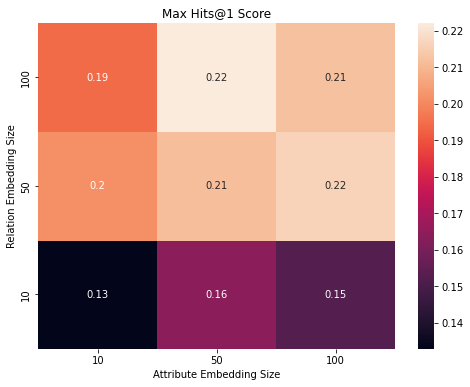

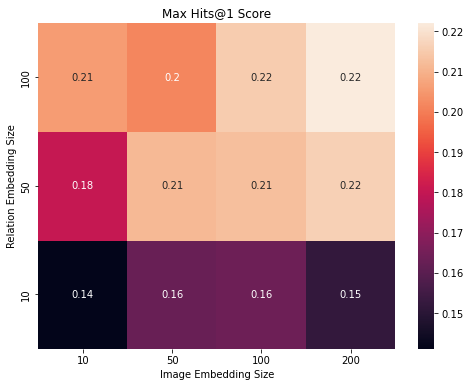

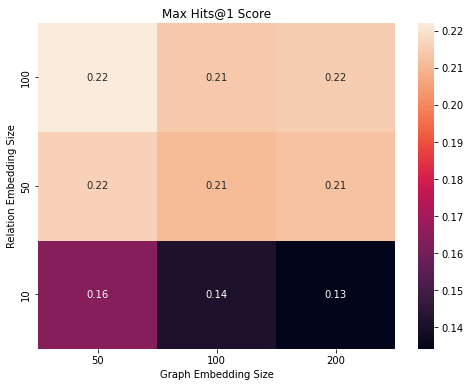

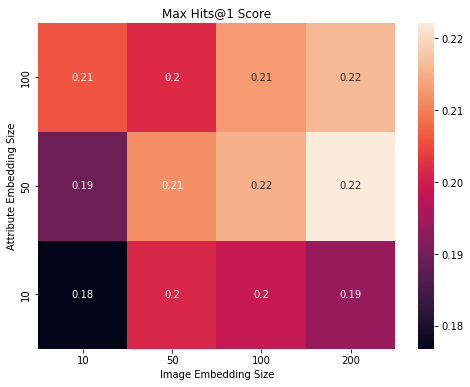

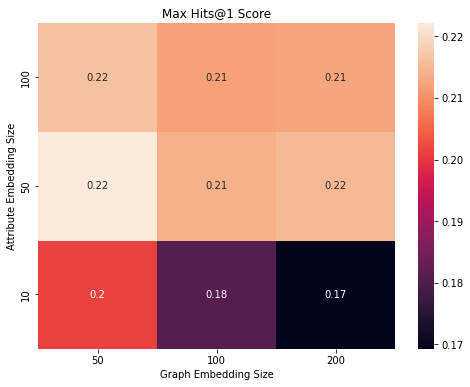

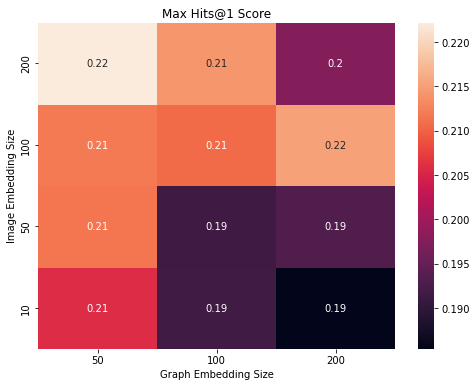

In [ ]:
colnames = (
    "Relation Embedding Size",
    "Attribute Embedding Size",
    "Image Embedding Size",
    "Graph Embedding Size",
)
valname = "Hits@1"
for i in range(len(colnames)):
    for ii in range(i+1, len(colnames)):
        max_scores = perf_df.groupby([colnames[i], colnames[ii]]).max()
        max_scores = max_scores.unstack()[valname]
        plt.figure(figsize=(8,6))
        ax = sns.heatmap(max_scores, annot=True)
        ax.invert_yaxis()
        ax.set_title("Max Hits@1 Score")
        plt.show()